In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
    CompoundNormSpectralModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
path_public_crab = "../Crab/HESS_public/"

In [4]:
sys_percentage = np.loadtxt(path_public_crab+"sysamplitude_percentage.txt")

In [5]:
crab_dataset = MapDataset.read(path_public_crab+"dataset-stacked.fits.gz")

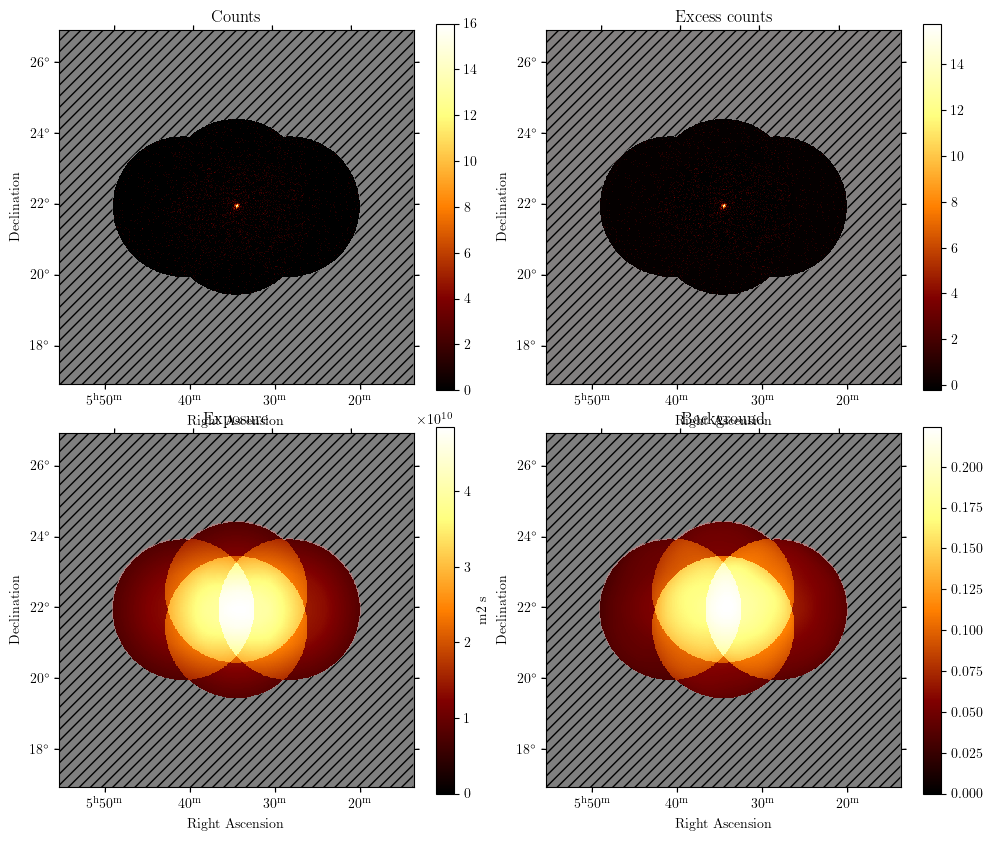

In [6]:
crab_dataset.peek()

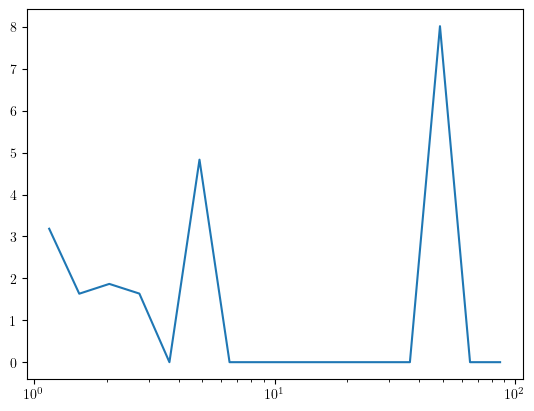

In [7]:
emask = crab_dataset.mask.data.sum(axis=2).sum(axis=1)>0
energy = crab_dataset.geoms['geom'].axes[0].center[emask]
plt.plot(energy, sys_percentage[emask])
plt.xscale('log')

In [8]:
logparabola = Models.read(path_public_crab+"model-lp.yaml")
logparabola_published = Models.read(path_public_crab+"model-lp.yaml")

bkg = FoVBackgroundModel(dataset_name=crab_dataset.name)
bkg.parameters['tilt'].frozen = False

crab_dataset.models = Models([logparabola[0], bkg])
print(crab_dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : LP
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.79e-10   +/- 3.0e-12 1 / (cm2 s TeV)
    reference             (frozen):      0.521       TeV         
    alpha                         :      2.100   +/-    0.04             
    beta                          :      0.240   +/-    0.01             
    lon_0                         :     83.630   +/-    0.00 deg         
    lat_0                         :     22.010   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt      

In [9]:
%%time
fit = Fit()
fit.run(crab_dataset)

update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
CPU times: user 25.8 s, sys: 6.24 s, total: 32 s
Wall time: 32 s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 295
	total stat : 69022.47

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1137: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


(<WCSAxes: >,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>)

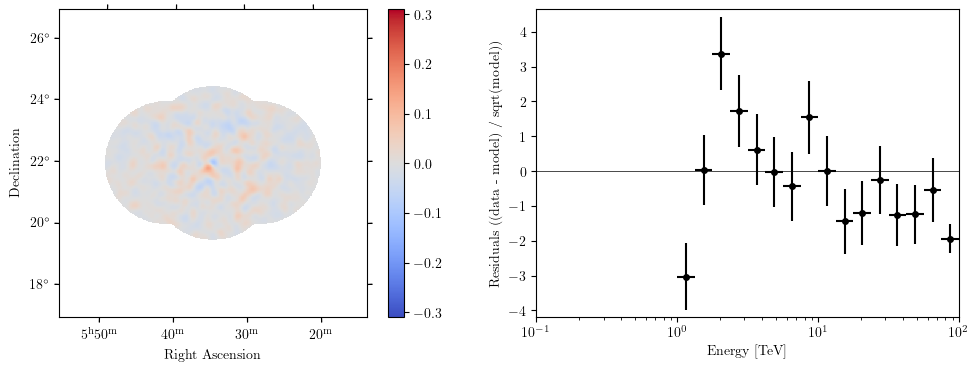

In [10]:
crab_dataset.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

In [11]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6, color = 'red'):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label, color = color)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                    fmt = fmts[j],
                    markersize = markersize[j], 
                        color = colors [j])
            except:
                pass

    plt.tight_layout()
    return fig

labels = ['published', 'fitted', 'fitted with BKG sys']
fmts = ['o','x', '*']
markersize = [6,10, 10]

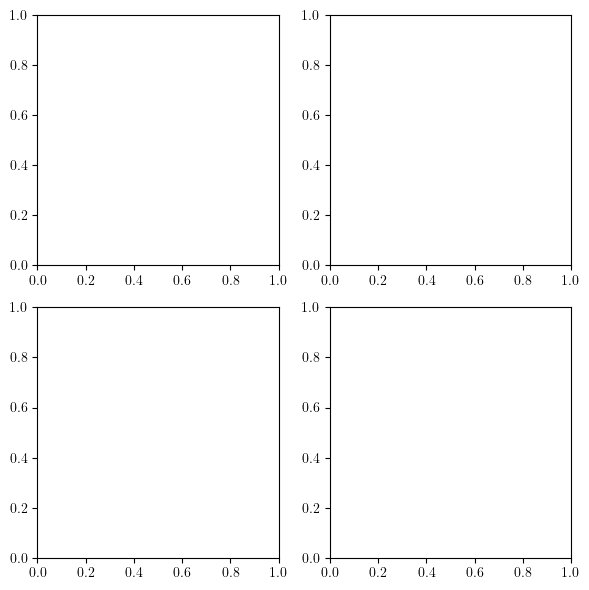

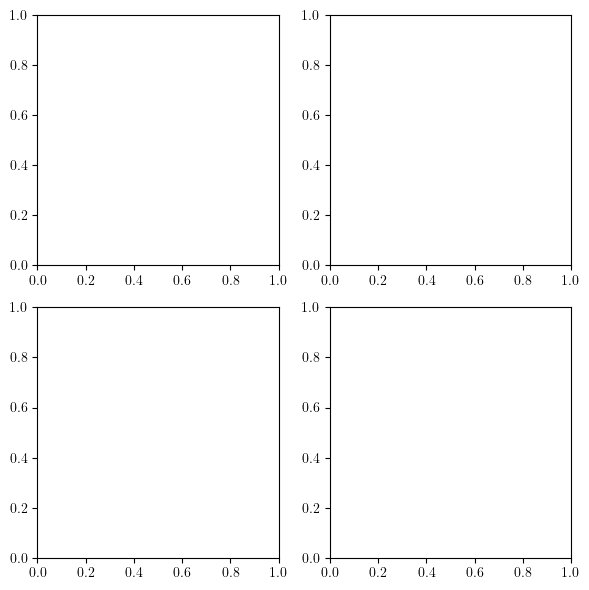

In [12]:
models_list = [logparabola_published, crab_dataset.models, ]

pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'reference'), ('alpha', 'beta')]
plot_source_par(0, pars)


## BKG Energybin wise systematic

In [13]:
l = len(energy)
norms = Parameters([Parameter ("norm"+str(i), value = 0, is_penalised = True, 
                               frozen = True) for i in range(len(energy))])
for i in range(len(norms)):
    if sys_percentage[emask][i] > 0:
        norms[i].frozen = False
piece = PiecewiseNormSpectralModel(energy = energy,
                          norms = norms)

import operator
bkg_spectral = CompoundNormSpectralModel(model1 = piece, 
                                        model2 = PowerLawNormSpectralModel(),
                                        operator= operator.add)

crab_dataset_sys = crab_dataset.copy(name = "Crab sys")
bkg_sys = FoVBackgroundModel(spectral_model = bkg_spectral,
                            dataset_name= crab_dataset_sys.name)
bkg_sys.parameters['tilt'].frozen = False
crab_dataset_sys.models = Models([logparabola_published[0].copy(), 
                                bkg_sys])

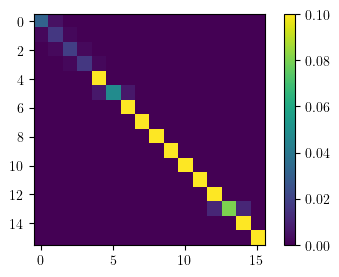

In [14]:
from scipy.stats import norm
l = len(energy) 
cov = np.ones((l,l)) * 1e-12
cov = np.identity(l)

# note: values set arbitrarily 
for i in range(l):
    if sys_percentage[emask][i] > 0:
        gau = norm.pdf(range(l) , loc = i , scale = 0.5 )
        cov[i,:] = gau / np.max(gau) * sys_percentage[emask][i] / 100 
        cov[i,:] += [1e-12] * (l)
fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(cov, vmin = 0, vmax = 0.1)
fig.colorbar(pos, ax=ax1)

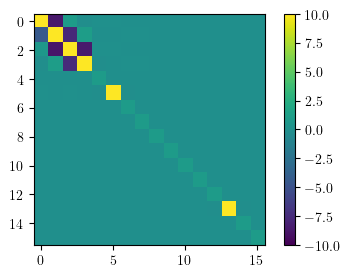

In [15]:
from numpy.linalg import inv
ainv = inv(cov)
crab_dataset_sys.penalising_invcovmatrix = ainv

fig, (ax1) = plt.subplots(figsize=(5, 3), ncols=1)
pos =plt.imshow(ainv, vmin = -10, vmax = 10)
fig.colorbar(pos, ax=ax1)

In [16]:
%%time
fit_sys = Fit()
fit_sys.run(crab_dataset_sys)

update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
CPU times: user 1min 23s, sys: 30.3 s, total: 1min 53s
Wall time: 1min 53s


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization terminated successfully.
	nfev       : 1458
	total stat : 69004.13

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

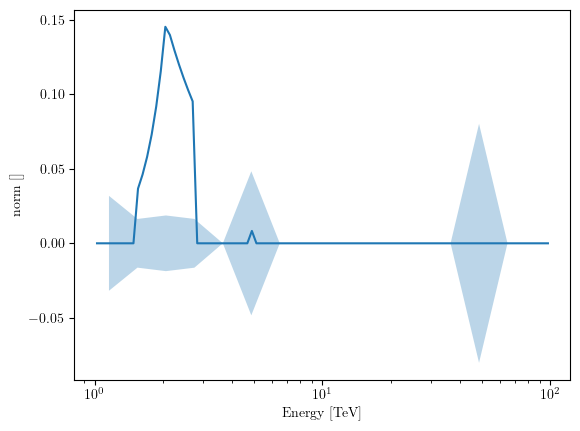

In [17]:
crab_dataset_sys.models[1].spectral_model.model1.plot([1,100]*u.TeV)
plt.fill_between(energy.value, sys_percentage[emask]/100,-sys_percentage[emask]/100,
                alpha = 0.3)

plt.yscale("linear")

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1137: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


(<WCSAxes: >,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>)

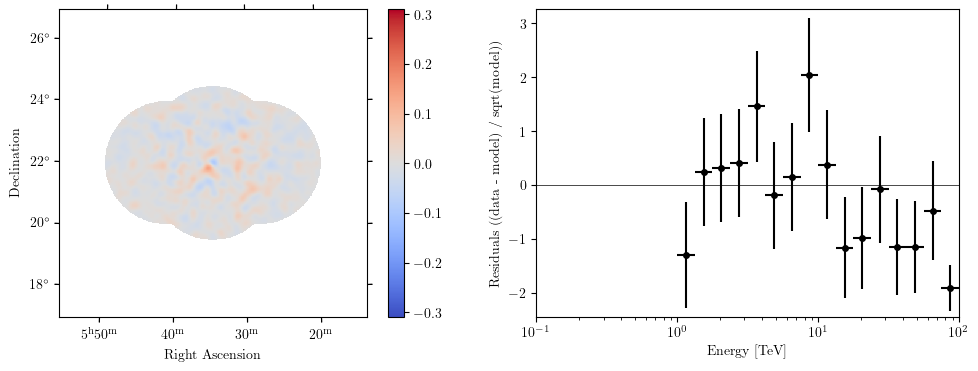

In [18]:
crab_dataset_sys.plot_residuals(kwargs_spatial={'vmax':0.31,
                                      'vmin':-0.31},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1137: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1137: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


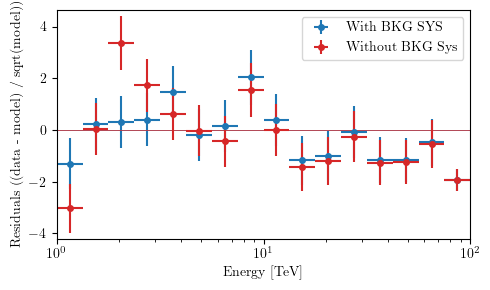

In [19]:
fig, ax = plt.subplots(figsize = (5,3))
ax = crab_dataset_sys.plot_residuals_spectral(method =  'diff/sqrt(model)', color = 'tab:blue',
                                             label = "With BKG SYS")
crab_dataset.plot_residuals_spectral(method =  'diff/sqrt(model)', color = 'tab:red', ax = ax,
                                    label = "Without BKG Sys")
#plt.fill_between(energy.value, sys_percentage[emask],-sys_percentage[emask],alpha = 0.3)
ax.legend()
ax.set_xlim(1,100)
plt.tight_layout()

fig = plt.gcf()
fig.savefig('plots/1_spectracl_res_points.png')

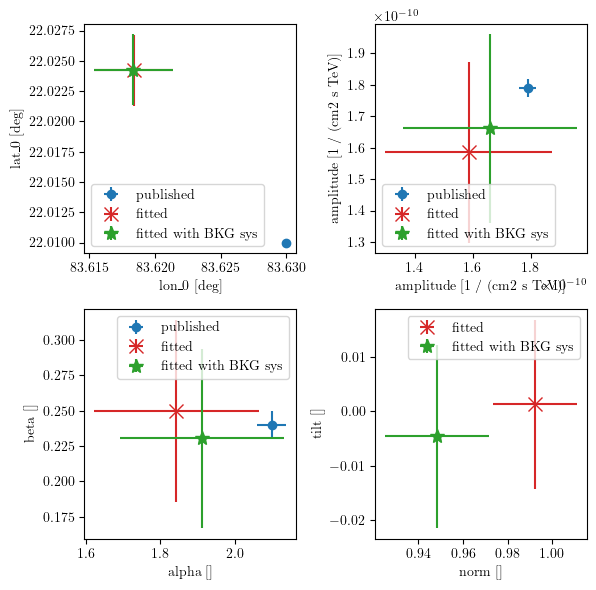

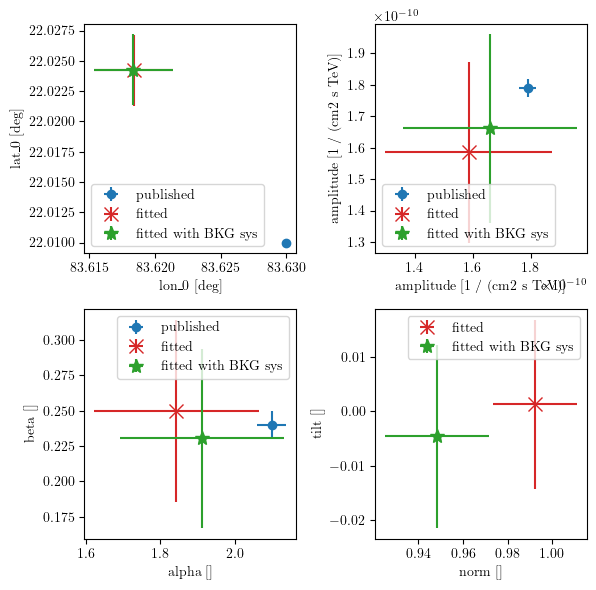

In [20]:
models_list = [logparabola_published, crab_dataset.models, crab_dataset_sys.models ]
colors = ['tab:blue', 'tab:red', 'tab:green']
pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'amplitude'), ('alpha', 'beta'),
               ('norm', 'tilt')]
plot_source_par(0, pars)


<Figure size 640x480 with 0 Axes>

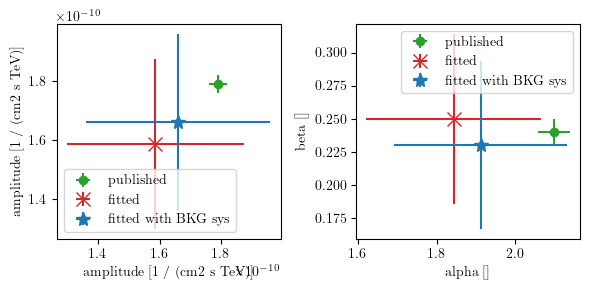

In [21]:
fig = plt.figure()
models_list = [logparabola_published, crab_dataset.models, crab_dataset_sys.models ]
colors = ['tab:green', 'tab:red', 'tab:blue']
pars =  pars = [('amplitude', 'amplitude'), ('alpha', 'beta')]
fig = plot_source_par(0, pars)
plt.tight_layout()
fig.savefig('plots/1_bestfitpars.png')


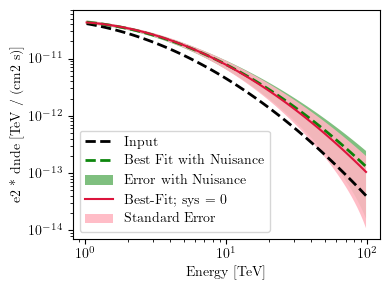

In [22]:
energy_bounds = (1, 100 ) * u.TeV

fig,axs = plt.subplots(1,1,figsize = (4,3))
energy_power=2
logparabola_published[0].spectral_model.plot(energy_bounds, energy_power = energy_power, ax =axs, 
                                label = "Input", color = 'black', linewidth = energy_power, linestyle="dashed")
crab_dataset_sys.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
crab_dataset_sys.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)

crab_dataset.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "Best-Fit; sys = 0%", color = "crimson")
crab_dataset.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

axs.legend() 
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.png")

In [23]:
print(crab_dataset_sys.models)

DatasetModels

Component 0: SkyModel

  Name                      : D7ve01aN
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.66e-10   +/- 3.0e-11 1 / (cm2 s TeV)
    reference             (frozen):      0.521       TeV         
    alpha                         :      1.912   +/-    0.22             
    beta                          :      0.230   +/-    0.06             
    lon_0                         :     83.618   +/-    0.00 deg         
    lat_0                         :     22.024   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : Crab sys-bkg
  Datasets names            : ['Crab sys']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm0                         :     -0.002   +/-    0.01             
    no

In [24]:
print(crab_dataset_sys.models)

DatasetModels

Component 0: SkyModel

  Name                      : D7ve01aN
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.66e-10   +/- 3.0e-11 1 / (cm2 s TeV)
    reference             (frozen):      0.521       TeV         
    alpha                         :      1.912   +/-    0.22             
    beta                          :      0.230   +/-    0.06             
    lon_0                         :     83.618   +/-    0.00 deg         
    lat_0                         :     22.024   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : Crab sys-bkg
  Datasets names            : ['Crab sys']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm0                         :     -0.002   +/-    0.01             
    no

## LimaSign

In [25]:
from gammapy.estimators import ExcessMapEstimator
from scipy.stats import norm


def com_excl_mask_2d(dataset):
    
    excl_regions = []
    box_center = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
    box = RectangleSkyRegion(center=box_center, width=4*u.deg, height=1.6*u.deg)
    #source_303 = CircleSkyRegion(center=cat['HESS J1745-303'].position, radius=1.2*u.deg)#was0.9
    source_303 = CircleSkyRegion(center=SkyCoord(358.71, -0.64, unit='deg', frame='galactic'), radius=0.9*u.deg)
    excl_regions = [box, source_303]
    geom= dataset.geoms["geom"]
    geom_2d = geom.slice_by_idx(dict(energy=1))
    excl_mask_2d = Map.from_geom(geom_2d, data=geom_2d.region_mask(excl_regions, inside=False).data)
    return excl_mask_2d


def compute_lima(dataset, edges):
        
    thr = 0.1
    estimator = ExcessMapEstimator(
        correlation_radius=corr_radius,
        selection_optional='all',
        energy_edges=edges,
    ) #was 0.1
    result = estimator.run(dataset)
    
    return result
    
def lima1a (dataset, result, title = None):

    if len(result["sqrt_ts"].geom.axes[0].center) ==1: 
        result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5)
        fig = plt.gcf()
        if title is not None:
            st = plt.suptitle(title + f"\n corr_radius = {corr_radius}")
            st.set_y(0.95)
            fig.subplots_adjust(top=0.85)
            fig.savefig(f"plots/9a-lima-{title}.pdf")
            fig.savefig(f"plots/9a-lima-{title}.svg")
    else:
        
        result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5)
        
        fig = plt.gcf()
        if title is not None:
            st = plt.suptitle(title+ f"\n corr_radius = {corr_radius}")
            st.set_y(0.95)
            fig.subplots_adjust(top=0.85)
            fig.savefig(f"plots/9a-lima-e-{title}.pdf")
            fig.savefig(f"plots/9a-lima-e-{title}.svg")
            
    return fig


    
def lima1b(result, title):    
    
    
    significance_data = result["sqrt_ts"].data
    
    print(result["sqrt_ts"].data.shape[0])


    selection = np.isfinite(significance_data) & ~(significance_data == 0)
    significance_data = significance_data[selection]

    plt.hist(significance_data, density=True, alpha=0.9, color="firebrick", bins=40)
    mu, std = norm.fit(significance_data)

    x = np.linspace(-5, 5, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x,p,lw=2,color="black",
             label=r"$\mu$ = {:.6f}, $\sigma$ = {:.6f}".format(mu, std),)
    
    
    p = norm.pdf(x, 0, 1)

    plt.plot(x,p,lw=2,color="tab:blue",
             label=r"$\mu$ = {:.3f}, $\sigma$ = {:.3f}".format(0, 1),)
    plt.legend(fontsize=14)
    plt.xlim(-5.5, 5.5)
    ax =plt.gca()
    plt.ylim(1e-4, ax.get_ylim()[1]) 
    plt.yscale('log')
    fig = plt.gcf()
    if title is not None:
        st = plt.suptitle(title + f"\n corr_radius = {corr_radius}")
        #fig.tight_layout()
        
        st.set_y(0.99)
        fig.subplots_adjust(top=0.85)
        fig.savefig(f"plots/9a-lima-dist-{title}.pdf")
        fig.savefig(f"plots/9a-lima-dist-{title}.svg")
        
    
    #pic=pic+1;plt.savefig(f'../tempo/{key}_{pic}.pdf');
    #plt.close() # res dist _6

    
   

In [26]:
corr_radius = 0.1* u.deg
thr = 1
titles = ["With BKG sys", "with out"]

In [27]:
%%time
computing = False
if computing:
    edges = [thr, 100] * u.TeV
    result_impact = compute_lima (crab_dataset_sys,edges)
    result_impact.write(f'data/1_lima_sys_{corr_radius}_deg.fits')    
else:
    from gammapy.estimators.map import FluxMaps
    result_impact= FluxMaps.read(f'data/1_lima_sys_{corr_radius}_deg.fits')

CPU times: user 73 ms, sys: 9.05 ms, total: 82 ms
Wall time: 83.6 ms


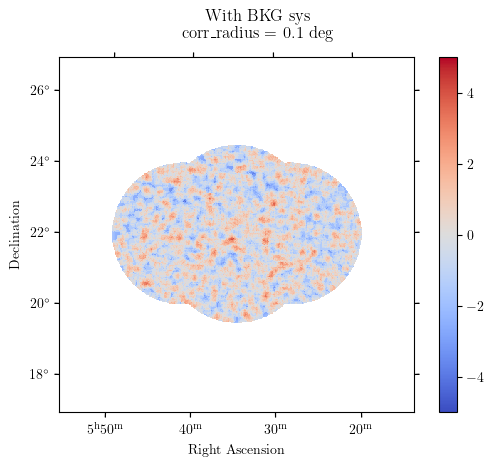

In [28]:
fig = lima1a(crab_dataset_sys, result_impact, titles[0])

1


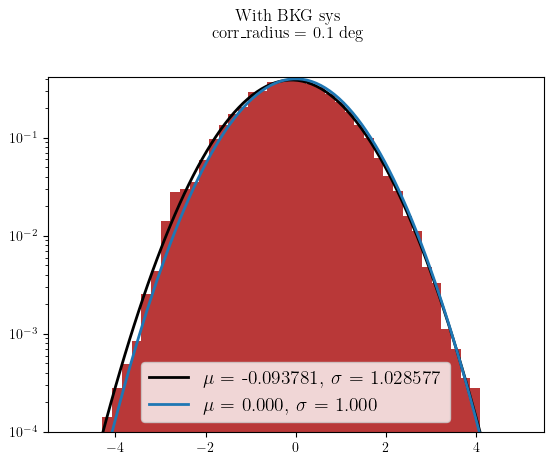

In [29]:
fig = lima1b( result_impact, titles[0])

### without

In [30]:
%%time
computing = False
if computing:
    edges = [thr, 100] * u.TeV
    result_crab = compute_lima (crab_dataset,edges)
    result_crab.write(f'data/1_lima_{corr_radius}_deg.fits')    
else:
    result_crab = FluxMaps.read(f'data/1_lima_{corr_radius}_deg.fits')    
    

CPU times: user 71.9 ms, sys: 14.2 ms, total: 86.2 ms
Wall time: 87.3 ms


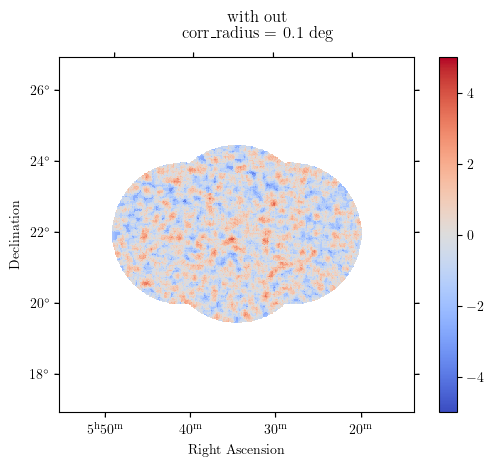

In [31]:
fig = lima1a(crab_dataset, result_crab, titles[1])

1


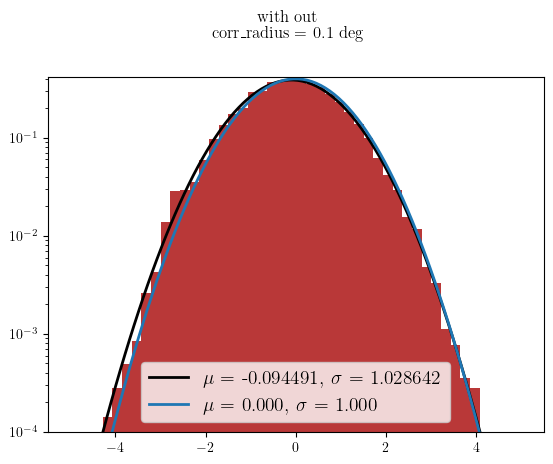

In [32]:
fig = lima1b( result_crab, titles[1])

## Fluxpoints

In [33]:
%%time
from gammapy.estimators import FluxPointsEstimator

fp_est_sys = FluxPointsEstimator(energy_edges=energy[::3], 
                                 source = crab_dataset_sys.models[0].name)
fp_sys = fp_est_sys.run(crab_dataset_sys)


1.1547819846894583 TeV 2.7384196342643614 TeV
update evaluator
norm 1.0055055835064117 0.062192421296066405
norm0 -0.001469177986346575 0.014315094764270184
norm1 0.03538333329919423 0.02849478157467136
norm2 0.14947083233658662 0.034922407901955395
norm3 0.015684621594005056 0.12682557644656908
norm4 0.008371211968783309 1.0001488125747926
norm5 -0.0017629231321016504 0.2198853541960323
norm6 0.0031458411309227543 1.0001106881396693
norm7 7.797771456000234e-06 1.000000000867396
norm8 3.632114575409413e-10 1.000000000187496
norm9 6.441106856788984e-14 1.000000000187496
norm10 0.0 1.000000000187496
norm11 -2.1553213786256287e-07 1.0000000013162809
norm12 -8.695396329367054e-05 1.0001836964312318
norm13 5.014729898194914e-05 0.28327225251380106
norm14 -8.695396329367054e-05 1.0001836964312318
norm15 -2.1553213786256287e-07 1.000000001316281
freeze for error
freeze for error
freeze for error
freeze for error
freeze for error
freeze for error
freeze for error
freeze for error
freeze for e

In [34]:
%%time
from gammapy.estimators import FluxPointsEstimator

fp_est = FluxPointsEstimator(energy_edges=energy[::3], 
                                 source = crab_dataset.models[0].name)
fp = fp_est.run(crab_dataset)


1.1547819846894583 TeV 2.7384196342643614 TeV
update evaluator
norm 1.0080427135895134 0.062119955346578264

2.7384196342643614 TeV 6.493816315762111 TeV
update evaluator
norm 0.9276273203765064 0.0934870140311897

6.493816315762111 TeV 15.399265260594923 TeV
update evaluator
norm 1.1854995868162093 0.2012506692141707

15.399265260594923 TeV 36.51741272548378 TeV
update evaluator
norm 0.6610167851730969 0.5802683063022236

36.51741272548378 TeV 86.59643233600663 TeV
update evaluator
norm 4.594412695081627 4.651739583300794
CPU times: user 7.14 s, sys: 323 ms, total: 7.46 s
Wall time: 7.47 s


(<Axes: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals\n (data - model) / model'>)

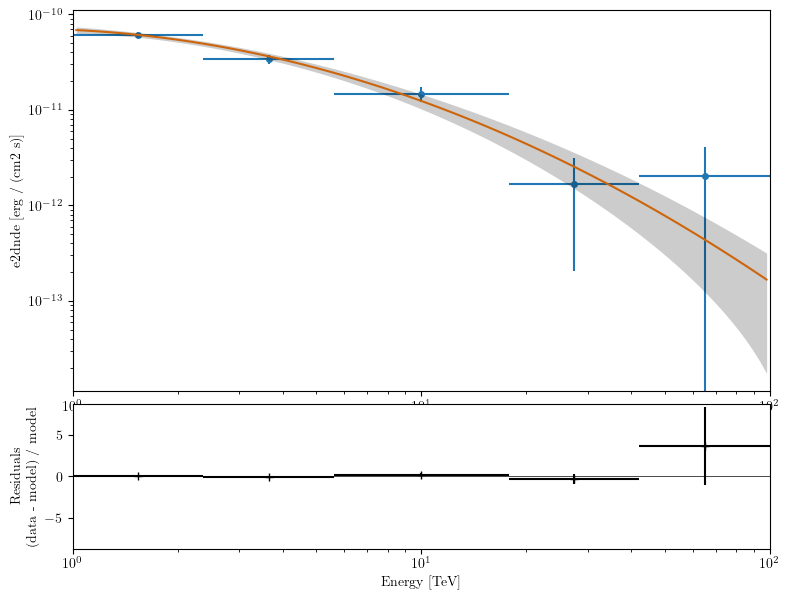

In [35]:
from gammapy.datasets import FluxPointsDataset
fp_dataset = FluxPointsDataset(data = fp, 
                              models = crab_dataset.models[0])
fp_dataset.plot_fit()

(<Axes: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals\n (data - model) / model'>)

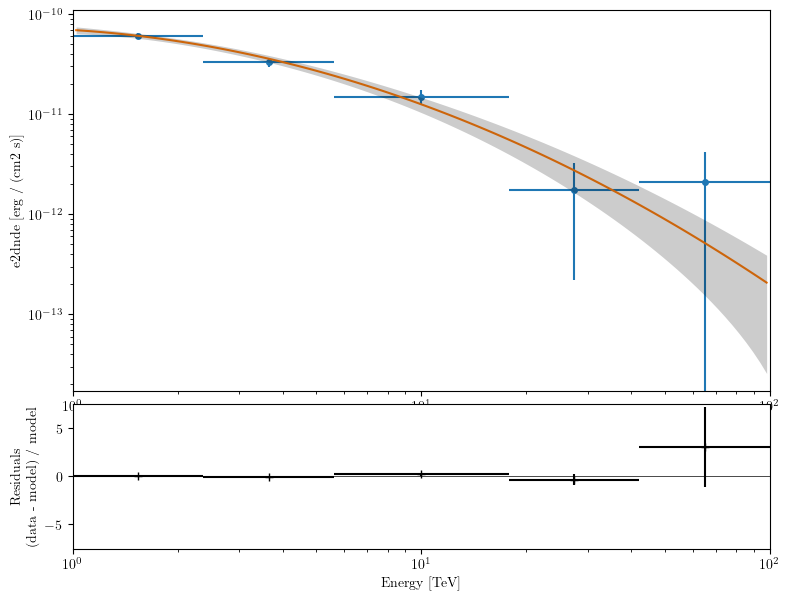

In [36]:
fp_sys_dataset = FluxPointsDataset(data = fp_sys, 
                              models = crab_dataset_sys.models[0])
fp_sys_dataset.plot_fit()